Tutorial: Task Dependency Management
====================================

Objective:

> Learning how ML workflows can be representated using acyclic task graphs, how to construct them and how they are essential to portability.

Principles:

1. Workflows are represented using dependencies of their tasks modeled by acyclic graphs.
2. The actual task graph can be displayed when selecting the `graphviz` runner.
3. Individual tasks are implemented using _Actors_ which can be _stateless_ or _stateful_.
4. _Train_ versus _Apply_ modes are represented using tightly coupled but distinct (in the case of stateful nodes) task graphs.
5. Operators are units of task graph topologies.
6. Operator composition is a non-linear operation combining two operators to produce more complex task graph topology.
7. Task graphs can be executed using different runners.

Actors
------

Representing the unit of work within the workflow - the vertices in the task graph.

Connected using _input_ and _output_ [ports](https://docs.forml.io/en/latest/workflow/actor.html#ports).

* system vs application ports

implementing:
* native
* decorated

modes:
* train vs apply

### Workflow Visualization

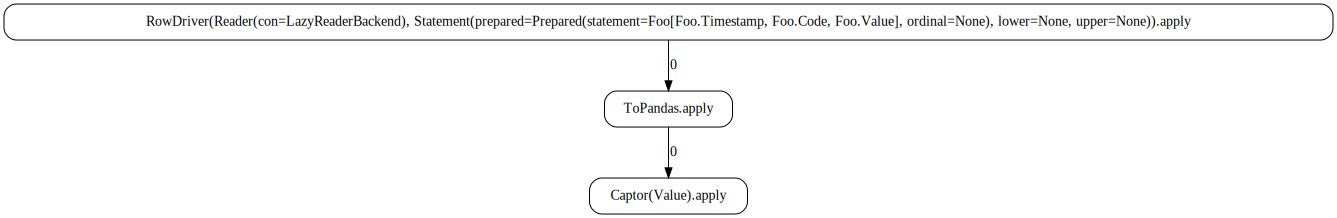

In [27]:
from forml import project
from forml.pipeline import payload
from dummycatalog import Foo

SOURCE = project.Source.query(Foo.select(Foo.Code, Foo.Value), labels=Foo.Label)
PIPELINE = payload.ToPandas()

SOURCE.bind(PIPELINE).launcher("graphviz").apply()

### Stateless Actor

In [17]:
import pandas
from forml.pipeline import wrap

@wrap.Operator.mapper
@wrap.Actor.apply
def LowerCase(data: pandas.DataFrame, *, column: str) -> pandas.DataFrame:
    data[column] = data[column].str.lower()
    return data

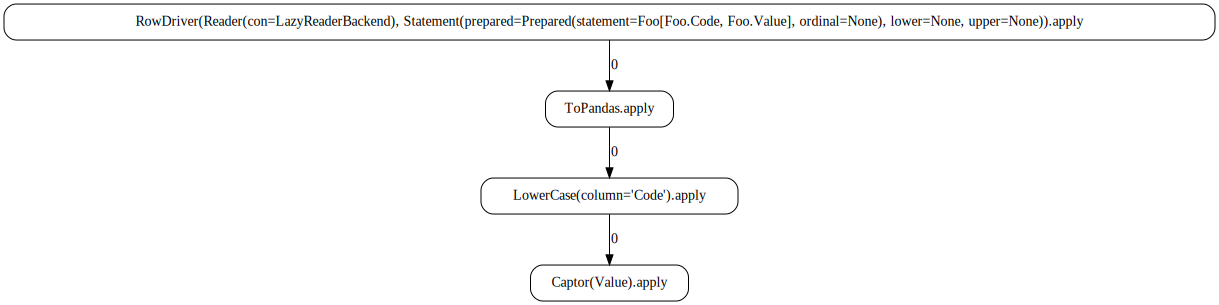

In [52]:
SOURCE = project.Source.query(Foo.select(Foo.Code, Foo.Value), labels=Foo.Label) >> payload.ToPandas()
PIPELINE = LowerCase(column="Code")

SOURCE.bind(PIPELINE).launcher("graphviz").apply()

In [53]:
SOURCE.bind(PIPELINE).launcher("dask").apply()

INFO: 2023-05-16 20:32:02,204: lazy: Loading Foo


,Code,Value
0,alpha,0.26
1,tango,0.14
2,zulu,0.57
3,bravo,0.45
4,charlie,0.83
5,delta,0.61
6,echo,0.12
7,golf,0.23
8,foxtrot,0.92
9,yankee,0.68


### Stateful Actor

In [40]:
import typing

@wrap.Actor.train
def Center(state: typing.Optional[float], data: pandas.DataFrame, labels: pandas.Series, *, column: str) -> float:
    return data[column].mean()

@wrap.Operator.mapper
@Center.apply
def Center(state: float, data: pandas.DataFrame, *, column: str) -> pandas.DataFrame:
    data[column] = data[column] - state
    return data

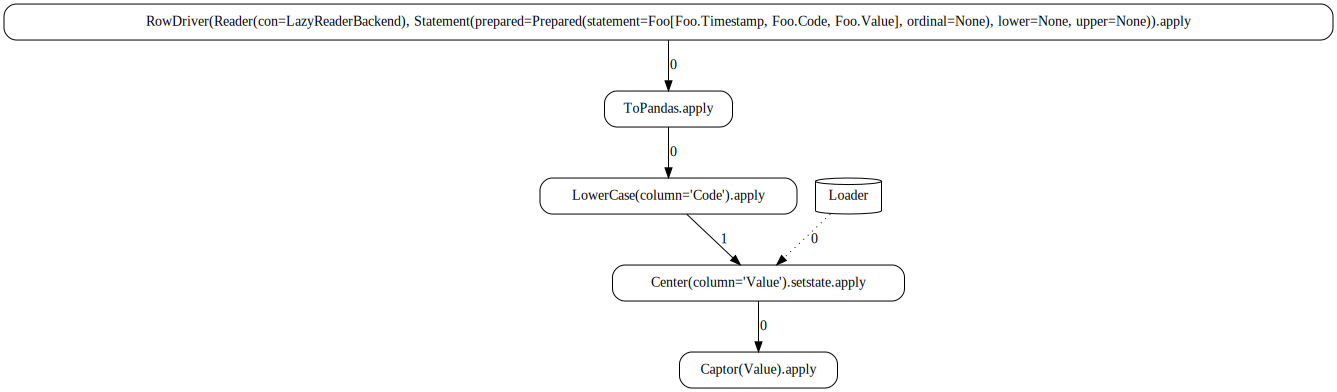

In [44]:
PIPELINE = LowerCase(column="Code") >> Center(column="Value")

SOURCE.bind(PIPELINE).launcher("graphviz").apply()

### Train-Apply Workflow Duality

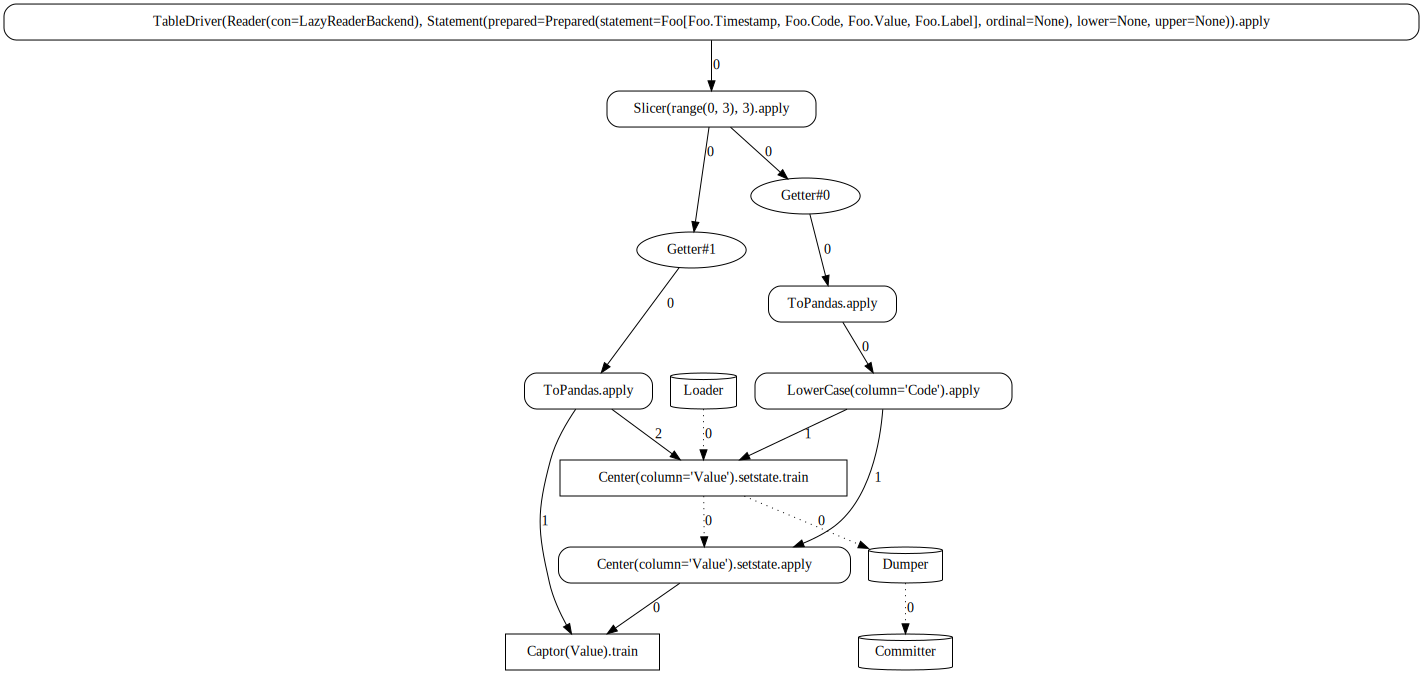

In [45]:
SOURCE.bind(PIPELINE).launcher("graphviz").train()

In [39]:
launcher = SOURCE.bind(PIPELINE).launcher("dask")
launcher.train()
launcher.apply()

,Timestamp,Code,Value
0,2021-05-05 03:12:19,alpha,-0.22
1,2021-05-11 11:27:50,tango,-0.34
2,2021-05-11 17:35:27,zulu,0.09
3,2021-05-06 19:49:43,bravo,-0.03
4,2021-05-12 08:53:35,charlie,0.35
5,2021-05-12 22:06:04,delta,0.13
6,2021-05-07 13:17:43,echo,-0.36
7,2021-05-13 16:25:18,golf,-0.25
8,2021-05-13 06:31:58,foxtrot,0.44
9,2021-05-08 15:48:20,yankee,0.20


Operators
---------

### Implementing Custom Operator

In [41]:
from imblearn import over_sampling
from forml import flow


@wrap.Actor.apply
def OverSampler(features: pandas.DataFrame, labels: pandas.Series, *, random_state: typing.Optional[int] = None):
    """Stateless actor  with two input and two output ports for oversampling the features/labels of the minor class."""
    return over_sampling.RandomOverSampler(random_state=random_state).fit_resample(
        features, labels
    )


class Balancer(flow.Operator):
    """Balancer operator inserting the provided sampler into the ``train`` & ``label`` paths."""

    def __init__(self, sampler: flow.Builder = OverSampler.builder(random_state=42)):
        self._sampler = sampler

    def compose(self, scope: flow.Composable) -> flow.Trunk:
        left = scope.expand()
        sampler = flow.Worker(self._sampler, 2, 2)
        sampler[0].subscribe(left.train.publisher)
        new_features = flow.Future()
        new_features[0].subscribe(sampler[0])
        sampler[1].subscribe(left.label.publisher)
        new_labels = flow.Future()
        new_labels[0].subscribe(sampler[1])
        return left.use(
            train=left.train.extend(tail=new_features),
            label=left.label.extend(tail=new_labels),
        )

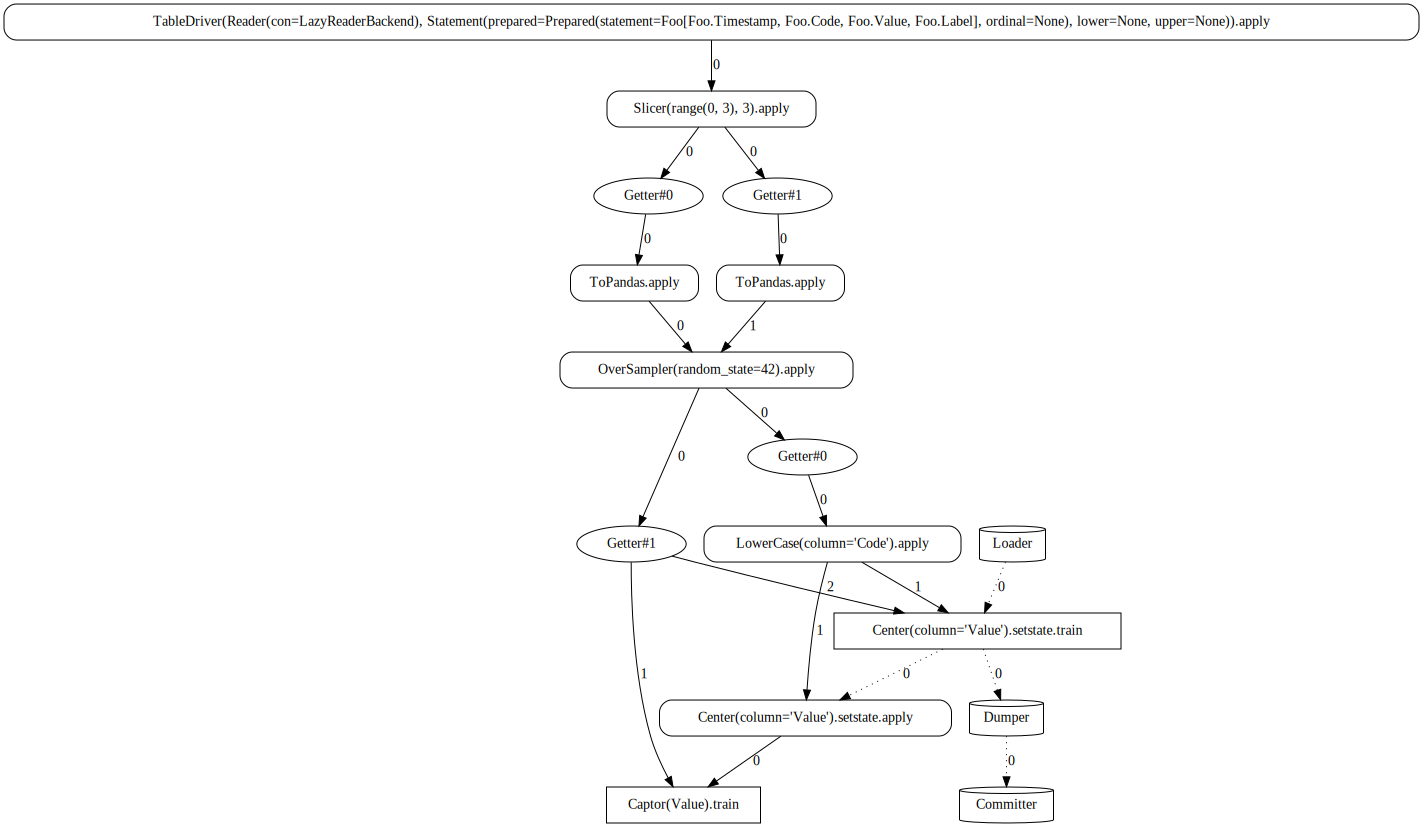

In [46]:
PIPELINE = Balancer() >> LowerCase(column="Code") >> Center(column="Value")

SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

### Operator Unit Testing

In [5]:
from forml import testing

class TestBalancer(testing.operator(Balancer)):
    """Balancer unit tests."""

    default_oversample = (
        testing.Case()
        .train([[1], [1], [0]], [1, 1, 0])
        .returns([[1], [1], [0], [0]], labels=[1, 1, 0, 0])
    )

In [6]:
import unittest
suite = unittest.TestSuite()
suite.addTest(TestBalancer('test_default_oversample'))

runner = unittest.TextTestRunner()
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 2.035s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Demonstrating Composition

### Auto-wrapping 3rd-party Components

In [50]:
with wrap.importer():
    from sklearn.linear_model import LogisticRegression

isinstance(LogisticRegression(), flow.Operator)

True

Pipeline
--------

* Creating simple pipeline with an estimator
* Specifying Target Column
* Composition with an Estimator

In [54]:
PIPELINE = Balancer() >> LowerCase(column="Code") >> Center(column="Value") >> LogisticRegression(random_state=42)

SOURCE.bind(PIPELINE).launcher(runner='dask').train()

INFO: 2023-05-16 20:32:24,365: lazy: Loading Foo
ERROR: 2023-05-16 20:32:24,756: __init__: Instruction LogisticRegression(random_state=42).setstate.train failed when processing arguments: b'',        Code  Value
0     alpha  -0.22
1     tango  -0.34
2      zulu   0.09
3     bravo  -0.03
4   charlie   0.35
5     delta   0.13
6      echo  -0.36
7      golf  -0.25
8   foxtrot   0.44
9    yankee   0.20
10     lima  -0.13
11    india   0.06
12  uniform  -0.41
13    romeo  -0.32
14    oscar   0.36
15   quebec   0.26
16    hotel  -0.03
17     papa   0.11
18   victor  -0.15
19    hotel   0.24, 0     1
1     1
2     0
3     1
4     0
5     0
6     1
7     1
8     0
9     0
10    1
11    0
12    1
13    1
14    0
15    0
16    1
17    0
18    1
19    0
Name: Label, dtype: int64
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/forml/flow/_code/target/__init__.py", line 56, in __call__
    result = self.execute(*args)
  File "/usr/local/lib/python3.10/site-package

ValueError: could not convert string to float: 'alpha'

Runners
-------

* Main Compute - Dask/Spark
* Alternative Runners - Graphviz, Pyfunc